In [1]:
from torchvision.transforms import ToTensor
from PIL import Image
import torch
from tqdm import tqdm
from scripts.voc_tools.voc_tools import visualize, return_files_in_directory, generate_mask_from_box, create_dataset,get_bounding_boxes, export_dataset, import_dataset
from tifffile import imread

def span_columns(max_x, max_y):
    cols = torch.zeros([max_y, max_x])
    for i in range(max_x):
        cols[:,i] = (i+1)
    return cols

def span_rows(max_x, max_y):
    rows = torch.zeros([max_y, max_x])
    for i in range(max_y):
        rows[i,:] = (i+1)
    return rows

def get_bbox_coordinates_one_box(tensor): 
    all_x, all_y = (tensor.squeeze() == 1).nonzero(as_tuple=True)
    smallest_x, smallest_y = torch.min(all_x).item(), torch.min(all_y).item()
    largest_x, largest_y = torch.max(all_x).item(), torch.max(all_y).item()
    return (smallest_y, smallest_x), (largest_y, largest_x)

def get_min_max_x(unique_tensor):
    unique_tensor = unique_tensor[unique_tensor!= 0]
    min_xs = []
    min_xs.append(unique_tensor[0].item())
    max_xs = []
    spotted_more_than_one_box = False
    for i in range(len(unique_tensor)):
        next_idx = (i+1)
        if next_idx <= (len(unique_tensor) -1):
            next_element = unique_tensor[next_idx]
            current_element = unique_tensor[i]
            diff = next_element - current_element
            if diff > 1:
                spotted_more_than_one_box = True
                min_xs.append(next_element.item())
                max_xs.append(current_element.item())
        else:
            current_element = unique_tensor[i]
            max_xs.append(current_element.item())
    return min_xs, max_xs, spotted_more_than_one_box



def get_min_max_y(base_tensor, min_xs, max_xs):
    ys = base_tensor[1]
    min_ys, max_ys = [], []
    # Slice tensor and extract values
    for idx, i in enumerate(min_xs):
        # slice colum wise
        start = int(i-1)
        end = int(max_xs[idx])
        slice = ys[:,start:end]
        # get unique values
        unique_tensor = torch.unique(slice)
        unique_tensor = unique_tensor[unique_tensor!= 0]
        min_ys.append(unique_tensor[0].item())
        for i in range(len(unique_tensor)):
                next_idx = (i+1)
                if next_idx <= (len(unique_tensor) -1):
                    next_element = unique_tensor[next_idx]
                    current_element = unique_tensor[i]
                    diff = next_element - current_element
                    if diff > 1:
                        min_ys.append(next_element.item())
                        max_ys.append(current_element.item())
                else:
                    current_element = unique_tensor[i]
                    max_ys.append(current_element.item())
    return min_ys, max_ys
    

def get_bbox_coordinates(tensor):
    # get base
    n_rows = tensor.shape[0]
    n_cols = tensor.shape[1]
    cols = span_columns(n_cols, n_rows)
    rows = span_rows(n_cols, n_rows)
    base = torch.zeros([2, n_rows, n_cols])
    base[0,:,:] = cols
    base[1,:,:] = rows
    res = tensor * base
    min_xs, max_xs, spotted_more_than_one_box = get_min_max_x(torch.unique(res[0]))
    if spotted_more_than_one_box == True:
        min_ys, max_ys  = get_min_max_y(res, min_xs, max_xs)
        # build min
        if len(min_xs) < len(min_ys):
            min_xs = [min_xs[-1] for i in range(len(min_ys))]
            max_xs = [max_xs[-1] for i in range(len(min_ys))]
        if len(min_ys) < len(min_xs):
            min_ys = [min_ys[-1] for i in range(len(min_xs))]
            max_ys = [max_ys[-1] for i in range(len(min_xs))]
        coord = [((min_xs[i], min_ys[i]), (max_xs[i], max_ys[i])) for i in range(len(min_xs))]
        return coord, spotted_more_than_one_box
    else:
        return get_bbox_coordinates_one_box(tensor), spotted_more_than_one_box

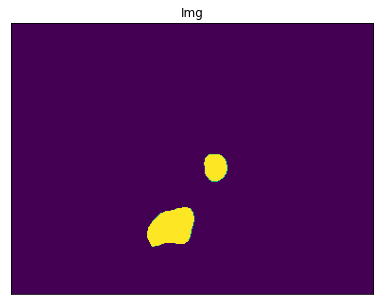

In [2]:
idx = 77
img = torch.Tensor(imread(f"./data/CVC-ClinicDB-1/Ground Truth/{idx}.tif")).long()
visualize(img=img)

In [3]:
image_with_many_classes = [71, 545, 546]

In [4]:
# for i in image_with_many_classes:
#     path = f"/Users/michaelgroeger/workspace/FEA_Internship/boxshrink/medical_ai_challenge/data/CVC-ClinicDB-1/Original/{i}.tif"
#     img = Image.fromarray(imread(path), mode="RGB")
#     output_path_mask = path.replace("Original", "multiple_findings").replace("tif", "png")
#     img.save(output_path_mask, quality=100, subsampling=0)

In [5]:
def get_bbox_coordinates_one_box(tensor): 
    all_x, all_y = (tensor.squeeze() == 1).nonzero(as_tuple=True)
    smallest_x, smallest_y = torch.min(all_x).item(), torch.min(all_y).item()
    largest_x, largest_y = torch.max(all_x).item(), torch.max(all_y).item()
    return (smallest_x, smallest_y), (largest_x, largest_y)

In [6]:
import numpy as np
# Function to generate masks from bounding boxes
def generate_mask_from_box_colonoscopy(
    image,
    smallest,
    largest,
):
    """Function to generate the box-like segmentation masks to be used uring training

    Args:
        dataset (csv): csv holding path to each considered xml file
        category_data (csv): csv: index,category,red,green,blue -> 1,person,192,128,128
        output_path (string): where to put the masks
    """
    image_width, image_height = image.shape[2], image.shape[1]
    # Create mask
    mask = np.zeros([image_height, image_width], dtype=np.uint8)
    # Get all boxes present on the image
    # get coordinates
    ymin, xmin, ymax, xmax = (
        smallest[1], smallest[0], largest[1], largest[0]
    )
    # Python does array[inclusive:exclusive] therefore we need to add + 1 to the max values
    # But then we also need to catch the case that the +1 will be out of the image
    if ymax != image_height:
        ymax = ymax + 1
    if xmax != image_width:
        xmax = xmax + 1
    mask[xmin:xmax, ymin:ymax] = 1
    mask = Image.fromarray(np.uint8(mask * 255) , 'L')
    return mask

In [10]:
pngs = return_files_in_directory("./data/CVC-ClinicDB-1/multiple_findings/colonoscopy-multiple-findings", ".png")
for png in pngs:
    img = Image.open(png).convert('L')
    name = png.split('/')[-1]
    img.save(f"./data/CVC-ClinicDB-1/multiple_findings/colonoscopy-multiple-findings/grayscale/{name}", quality=100, subsampling=0)

In [200]:
def infer_all_bboxes(mask_dir, box_dir):
    # get all masks from dir
    files = return_files_in_directory(mask_dir, ending=".tif")
    for idx, mask_path in tqdm(enumerate(files), desc="Creating Boxes from masks"):
        # load image
        image = Image.open(mask_path)
        image = ToTensor()(image)
        # map all positive values to 1
        image[image>0] = 1.0
        # get box coordinates
        smallest, largest = get_bbox_coordinates(image)
        # infer mask
        bb_mask = generate_mask_from_box_colonoscopy(image=image, smallest=smallest, largest=largest)
        # save mask to new dir
        output_path_mask = (
            box_dir + "/" + mask_path.split('/')[-1]
        ).replace("tif", "png")
        bb_mask.save(output_path_mask, quality=100, subsampling=0)

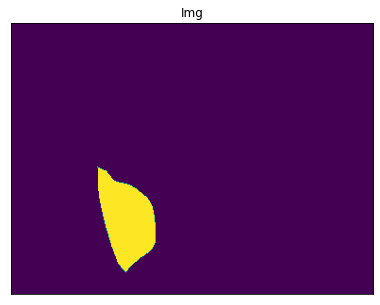

In [201]:
idx = 351

image = Image.open(f"./data/CVC-ClinicDB-1/Ground Truth/{idx}.tif")
image = ToTensor()(image)
visualize(img=image.permute(1,2,0))

In [202]:
xml_path = "./data/CVC-ClinicDB-1/multiple_findings/colonoscopy-multiple-findings"
category_path = "./data/CVC-ClinicDB-1/multiple_findings/colonoscopy-multiple-findings/color_codes.csv"
xmls = return_files_in_directory(xml_path, ending='xml')

In [229]:
ds = create_dataset(xmls, "name", condition="1")

Creating dataset: 100%|██████████| 30/30 [00:00<00:00, 423.30it/s]


In [232]:
export_dataset(ds[0], "./data/CVC-ClinicDB-1/multiple_findings/colonoscopy-multiple-findings/dataset.csv")

In [233]:
dsi = import_dataset("./data/CVC-ClinicDB-1/multiple_findings/colonoscopy-multiple-findings/dataset.csv")
generate_mask_from_box(dsi, category_path, "./data/CVC-ClinicDB-1/multiple_findings/colonoscopy-multiple-findings")

Creating Masks: 100%|██████████| 30/30 [00:00<00:00, 38.47it/s]
